# KNN

In [98]:
from preprocessing import *

In [99]:
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.metrics import f1_score, precision_score, accuracy_score,\
                            recall_score, roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

sns.set()

df_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1i-KJ2lSvM7OQH0Yd59bX01VoZcq8Sglq')
df_decision = pd.read_csv('https://drive.google.com/uc?export=download&id=1km-AEIMnWVGqMtK-W28n59hqS5Kufhd0')

In [100]:
df_data.head()

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede
0,4d,Señor Camilo Pedro,117,hombre,73.5,0,0,59258;,1,NaN,fiumark_quilmes
1,4d,Señora Raquel Angelica,658,mujer,35.0,1,1,586:6;,2,NaN,fiumark_quilmes
2,normal,Señor Antonio Federico,794,hombre,NaN,0,0,"RE""39822",3,NaN,fiumark_chacarita
3,4d,Señor Osvaldo Aureliano,455,hombre,NaN,0,0,"C17""4:39",1,NaN,fiumark_palermo
4,4d,Señorita Rita Eudosia,173,mujer,4.0,1,1,569964,2,NaN,fiumark_palermo


## Preprocesado 1

In [101]:
columnillas = ['tipo_de_sala_4d', 'tipo_de_sala_normal', 'tipo_de_sala_nan', 'id_usuario', 'genero_mujer', 'genero_nan', 
              'edad', 'amigos', 'parientes', 'precio_ticket', 
              'nombre_sede_fiumark_palermo', 'nombre_sede_fiumark_quilmes', 'nombre_sede_nan', 
              'cant_acompañantes']

In [102]:
# Asi me ahorro copy pastear esta celda varias veces
def correr_todos_los_preprocesados(dataset, columnas):
    df = eliminar_features_que_no_aportan_info(dataset, True)
    df = crear_feature_acompañantes(df)
    df = replace_nulls_column(df, 'edad', 'media')
    df = normalizar_atributos_numericos(df)
    df = encodear_atributos_categoricos(df)
    df = df.reindex(columns = columnas)
    return df

In [103]:
volver = ['volveria']
columnas = columnillas + volver

In [104]:
dataset = pd.merge(df_data, df_decision, how='inner', left_on='id_usuario', right_on='id_usuario')

df = correr_todos_los_preprocesados(dataset, columnas)

df.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,precio_ticket,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,cant_acompañantes,volveria
0,1,0,0,0.130337,0,0,0.880653,0.000,0.000000,0.000000,0,1,0,0.0,0.0
1,1,0,0,0.738202,1,0,0.396985,0.125,0.166667,0.020408,0,1,0,0.2,0.0
2,0,1,0,0.891011,0,0,0.368090,0.000,0.000000,0.040816,0,0,0,0.0,0.0
3,1,0,0,0.510112,0,0,0.368090,0.000,0.000000,0.000000,1,0,0,0.0,0.0
4,1,0,0,0.193258,1,0,0.007538,0.125,0.166667,0.020408,1,0,0,0.2,1.0


In [105]:
df.shape

(801, 15)

## Entrenamiento

In [106]:
# parametros: df y columnillas
def train_knn (df, df_columns):
    X = df.loc[:, df_columns]
    y = df.loc[:, 'volveria']
    print("X.shape: ", X.shape)
    print("y.shape: ", y.shape, "\n")
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=117)
    params = {'n_neighbors': np.arange(3, 10),
          'weights': ['uniform','distance'],
          'algorithm': ['auto', 'ball_tree', 'kd_tree'],
          'leaf_size': np.arange(15, 40),
          'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
             }
    model_knn = KNeighborsClassifier()
    rgscv = GridSearchCV(model_knn, params, scoring='roc_auc', cv=5, return_train_score=True
                        ).fit(X_train, y_train)
    print(f"Best score: {rgscv.best_score_}")
    print(f"Best params {rgscv.best_params_}\n")
    knn = apply_stratified_k_fold_to_knn(X, y, rgscv.best_params_)
    return knn, X_test, y_test

    
def apply_stratified_k_fold_to_knn (X, y, best_params):
    kf = StratifiedKFold(n_splits=5)
    test_rocs = []
    for fold_idx, (train_index, test_index) in enumerate(kf.split(X, y)):
        knn = KNeighborsClassifier( 
                n_neighbors = best_params['n_neighbors'],
                weights = best_params['weights'],
                algorithm = best_params['algorithm'],
                leaf_size = best_params['leaf_size'],
                metric= best_params['metric']
        )
        knn.fit(X.iloc[train_index], y.iloc[train_index])
        test_roc = roc_auc_score(y.iloc[test_index], knn.predict(X.iloc[test_index]))
        print(f"Fold {fold_idx}: AUC ROC score is {test_roc:.4f}")
        test_rocs.append(test_roc)
    print(f"Mean test AUC ROC is: {np.mean(test_rocs):.4f}")
    return knn
    
knn, X_test, y_test = train_knn(df, columnillas)

X.shape:  (801, 14)
y.shape:  (801,) 

Best score: 0.8464098249149508
Best params {'algorithm': 'auto', 'leaf_size': 15, 'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}

Fold 0: AUC ROC score is 0.7277
Fold 1: AUC ROC score is 0.7704
Fold 2: AUC ROC score is 0.8051
Fold 3: AUC ROC score is 0.7976
Fold 4: AUC ROC score is 0.7920
Mean test AUC ROC is: 0.7785


## Métricas

In [107]:
# parametros:knn, X_test, y_test
def get_scores(model, X, y):
    scores = {}
    scores['AUC ROC'] = roc_auc_score(y, model.predict_proba(X)[:,1])
    scores['Accuracy'] = accuracy_score(y, model.predict(X))
    scores['Precision'] = precision_score(y, model.predict(X))
    scores['Recall'] = recall_score(y, model.predict(X), pos_label=0)
    scores['F1-Score'] = f1_score(y, model.predict(X))

    for score in scores:
        print(f"{score} : {scores[score]:.4f}")
    return scores

scores = get_scores(knn, X_test, y_test)

AUC ROC : 0.9758
Accuracy : 0.9751
Precision : 1.0000
Recall : 1.0000
F1-Score : 0.9650


## Matriz de confusión

/home/anarella/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0.0, 1.0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


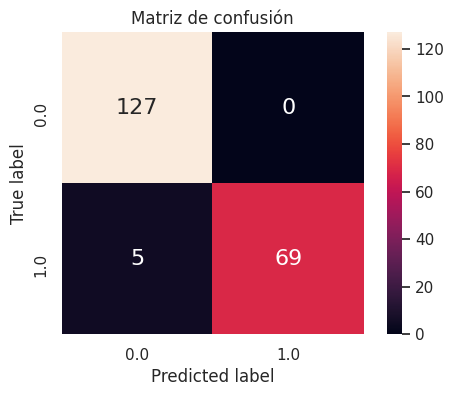

In [108]:
def plot_confusion_matrix(y_true, y_pred):
    names = sorted(set(y_true))
    cm = confusion_matrix(y_true, y_pred, names)
    df_cm = pd.DataFrame(cm, names, names)

    plt.figure(dpi=100)
    plt.title("Matriz de confusión")
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


plot_confusion_matrix(y_test, knn.predict(X_test))

## Test Holdout

In [109]:
holdout = pd.read_csv('https://drive.google.com/uc?export=download&id=1I980-_K9iOucJO26SG5_M8RELOQ5VB6A')

In [110]:
df_h = correr_todos_los_preprocesados(holdout, columnillas)
df_h.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,precio_ticket,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,cant_acompañantes
0,1,0,0,0.751756,1,0,0.344774,0.0,0.0,0.000000,1,0,0,0.0
1,1,0,0,0.264637,1,0,0.063963,0.5,0.4,0.061224,1,0,0,0.6
2,0,1,0,0.026932,0,0,0.609984,0.0,0.0,0.040816,0,0,0,0.0
3,0,0,0,0.637002,0,0,0.407176,0.0,0.0,0.040816,1,0,0,0.0
4,1,0,0,0.471897,0,0,0.450858,0.0,0.0,0.000000,1,0,0,0.0


In [128]:
#parametros: df_h, knn
def evaluate_holdout(holdout_df, model):
    y_pred = model.predict(holdout_df)
    y_pred = y_pred.astype(int)
    print("y_pred.shape: ", y_pred.shape)
    print("holdout_df.shape: ", holdout_df.shape, "\n")
    serie_predicha = pd.Series(y_pred, name='volveria')
    serie_predicha = serie_predicha.to_frame()
    df_predicho = holdout.join(serie_predicha, how='inner')
    cols = ['id_usuario', 'volveria']
    df_resultado = df_predicho[cols]
    return df_resultado

df_resultado = evaluate_holdout(df_h, knn)
df_resultado.head(15)

y_pred.shape:  (90,)
holdout_df.shape:  (90, 14) 



,id_usuario,volveria
0,650,0
1,234,0
2,31,0
3,552,0
4,411,0
5,134,1
6,497,1
7,434,0
8,528,1
9,112,0


In [112]:
df_resultado.to_csv('prediccion/knn_resultado_final.csv')

## Preprocesado 2

In [113]:
def segundo_set_de_preprocesados(dataset, columnas):
    df = eliminar_features_que_no_aportan_info(dataset, False)
    df = replace_nulls_column(df, 'edad', 'media')
    df = normalizar_atributos_numericos(df)
    df = encodear_atributos_categoricos(df)
    df = df.reindex(columns = columnas)
    return df

In [114]:
seguidores = ['cant_acompañantes']
columnas_nuevas = set(columnas) - set(seguidores)
columnas_nuevas

{'amigos',
 'edad',
 'genero_mujer',
 'genero_nan',
 'id_usuario',
 'nombre_sede_fiumark_palermo',
 'nombre_sede_fiumark_quilmes',
 'nombre_sede_nan',
 'parientes',
 'precio_ticket',
 'tipo_de_sala_4d',
 'tipo_de_sala_nan',
 'tipo_de_sala_normal',
 'volveria'}

In [115]:
df_2 = segundo_set_de_preprocesados(dataset, columnas_nuevas)
df_2.head()

,tipo_de_sala_normal,tipo_de_sala_nan,volveria,edad,amigos,parientes,tipo_de_sala_4d,precio_ticket,nombre_sede_fiumark_quilmes,genero_mujer,nombre_sede_nan,nombre_sede_fiumark_palermo,id_usuario,genero_nan
0,0,0,0.0,0.880653,0.000,0.000000,1,0.000000,1,0,0,0,0.130337,0
1,0,0,0.0,0.396985,0.125,0.166667,1,0.020408,1,1,0,0,0.738202,0
2,1,0,0.0,0.368090,0.000,0.000000,0,0.040816,0,0,0,0,0.891011,0
3,0,0,0.0,0.368090,0.000,0.000000,1,0.000000,0,0,0,1,0.510112,0
4,0,0,1.0,0.007538,0.125,0.166667,1,0.020408,0,1,0,1,0.193258,0


In [116]:
df_2.shape

(801, 14)

In [117]:
columnas_2 = ['genero_mujer', 'genero_nan', 'tipo_de_sala_normal', 'tipo_de_sala_nan', 'tipo_de_sala_4d', 
               'edad', 'nombre_sede_nan', 'nombre_sede_fiumark_palermo', 'nombre_sede_fiumark_quilmes',
              'amigos', 'precio_ticket', 'precio_ticket', 'id_usuario']

In [118]:
knn_2, X_test_2, y_test_2 = train_knn(df_2, columnas_2)

X.shape:  (801, 13)
y.shape:  (801,) 

Best score: 0.8449964826129082
Best params {'algorithm': 'auto', 'leaf_size': 15, 'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}

Fold 0: AUC ROC score is 0.7035
Fold 1: AUC ROC score is 0.7887
Fold 2: AUC ROC score is 0.7887
Fold 3: AUC ROC score is 0.7938
Fold 4: AUC ROC score is 0.7737
Mean test AUC ROC is: 0.7697


## Métricas

In [120]:
scores_2 = get_scores(knn_2, X_test_2, y_test_2)

AUC ROC : 0.9819
Accuracy : 0.9701
Precision : 0.9857
Recall : 0.9921
F1-Score : 0.9583


/home/anarella/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0.0, 1.0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


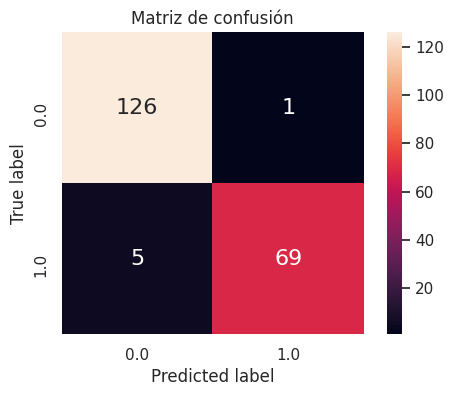

In [121]:
plot_confusion_matrix(y_test_2, knn_2.predict(X_test_2))

### 2do holdout

In [129]:
df_h_2 = segundo_set_de_preprocesados(holdout, columnas_nuevas)

df_h_2.head()

,tipo_de_sala_normal,tipo_de_sala_nan,volveria,edad,amigos,parientes,tipo_de_sala_4d,precio_ticket,nombre_sede_fiumark_quilmes,genero_mujer,nombre_sede_nan,nombre_sede_fiumark_palermo,id_usuario,genero_nan
0,0,0,NaN,0.344774,0.0,0.0,1,0.000000,0,1,0,1,0.751756,0
1,0,0,NaN,0.063963,0.5,0.4,1,0.061224,0,1,0,1,0.264637,0
2,1,0,NaN,0.609984,0.0,0.0,0,0.040816,0,0,0,0,0.026932,0
3,0,0,NaN,0.407176,0.0,0.0,0,0.040816,0,0,0,1,0.637002,0
4,0,0,NaN,0.450858,0.0,0.0,1,0.000000,0,0,0,1,0.471897,0


In [130]:
df_h_2 = df_h_2.drop(['volveria'], axis=1)
df_resultado_2 = evaluate_holdout(df_h_2, knn_2)
df_resultado_2.head(15)

y_pred.shape:  (90,)
holdout_df.shape:  (90, 13) 



,id_usuario,volveria
0,650,0
1,234,0
2,31,1
3,552,0
4,411,0
5,134,0
6,497,1
7,434,0
8,528,1
9,112,0


In [131]:
df_resultado.to_csv('prediccion/knn_2do_prepoc_resultado_final.csv')